In [1]:
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import glob

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
import cmocean.cm as cm

from dask.distributed import Client

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35879/status,
Dashboard: /proxy/35879/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35759,Workers: 28
Dashboard: /proxy/35879/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:38871,Total threads: 1
Dashboard: /proxy/40611/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:36723,


In [3]:
pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/*/*ocean_month_z.nc'))[120:]
pathsM = np.sort(glob.glob('/g/data/g40/akm157/model_output/mom6-panan/panant-005-zstar-ssp126-MW-only/*/*ocean_month_z.nc'))

In [4]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [5]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['deptho']
land_mask = (depth*0).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_005')

In [ ]:
def preprocess(ds):
    ds = ds[['thetao', 'so']].where(shelf_mask == 1)
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [ ]:
# Time slicing
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [ ]:
import gsw

In [ ]:
#### Calculatin

In [ ]:
# Calculating pressure
p_cont = gsw.p_from_z(-cont['z_l'], cont['yh'])
p_melt = gsw.p_from_z(-melt['z_l'], melt['yh'])

# Calculating absolute salinity
SA_cont = gsw.SA_from_SP(cont['so'], p_cont, cont['xh'], cont['yh'])
SA_melt =  gsw.SA_from_SP(melt['so'], p_melt, melt['xh'], melt['yh'])

# Calculating conservative temperature
tempC = gsw.CT_from_pt(SA_cont,cont['thetao'])
tempM = gsw.CT_from_pt(SA_melt,melt['thetao'])

In [ ]:
# To fix the label issues
tempC = xr.DataArray(tempC, dims=cont['thetao'].dims, coords=cont['thetao'].coords)
tempC.attrs['units'] = '°C'
tempC.name = 'CT'

tempM = xr.DataArray(tempM, dims=melt['thetao'].dims, coords=melt['thetao'].coords)
tempM.attrs['units'] = '°C'
tempM.name = 'CT'

In [ ]:
tempC = tempC.astype('float32')
tempM = tempM.astype('float32')
tempM

In [ ]:
saltC = cont['so']
saltM = melt['so']

In [ ]:
temp_anom = tempM - tempC
salt_anom = saltM - saltC

In [ ]:
area = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')['areacello']

var = cont['so'].isel(time=0,z_l=0)

# Correcting area
area_corr = area*(var_C*0 +1)

In [ ]:
area_corr.plot()

In [ ]:
# Taking the sum - control and melt areas are the same so only using control here.
shelf_area = area_corr.where(shelf_mask == 1).cf.sum({'longitude', 'latitude'}).load()

In [ ]:
temp_hov = (area_corr * temp_anom).cf.sum({'longitude', 'latitude'}) / shelf_area
salt_hov = (area_corr * salt_anom).cf.sum({'longitude', 'latitude'}) / shelf_area
temp_hov

In [ ]:
temp_hov = temp_hov.load()

In [ ]:
salt_hov = salt_hov.load()

In [ ]:
temp_hov.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/hov_temp_pan005.nc')
salt_hov.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/salt_temp_pan005.nc')

# Plotting

In [6]:
temp_hov = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/hov_temp_pan005.nc')
salt_hov = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/salt_temp_pan005.nc')

In [7]:
temp_hov

<xarray.DataArray (time: 120, z_l: 75)> Size: 36kB
[9000 values with dtype=float32]
Coordinates:
  * z_l      (z_l) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [8]:
def plot_hovmoller_shelf(fsize = 14, date_format = mdates.DateFormatter('%Y')):
    
    # Set figures properties
    plt.rcParams['font.size'] = fsize
    plt.rcParams['xtick.labelsize'] = fsize-2
    plt.rcParams['ytick.labelsize'] = fsize-2
    
    fig = plt.figure(figsize=(10, 9))
    grid = GridSpec(100, 100)
    
    ax = [fig.add_subplot(grid[:30, :30]), fig.add_subplot(grid[:30, 33:63])]
    
    for i in range(len(ax)):
        ax[i].tick_params(axis='x')#, labelrotation=45)
        if i != 0 and i != 2:
            ax[i].set_yticklabels([]) 

    return fig, ax

In [9]:
# Original monthly time coordinates
time_vals = temp_hov.time.values
n_years = 10
months_per_year = 12

# Tick positions: start of each year
tick_positions = time_vals[::months_per_year].tolist()  # first month of each year

# Add the very last month as the final tick
tick_positions.append(time_vals[-1])

# Tick labels: 0, 1, ..., 10
tick_labels = np.arange(0, n_years + 1)

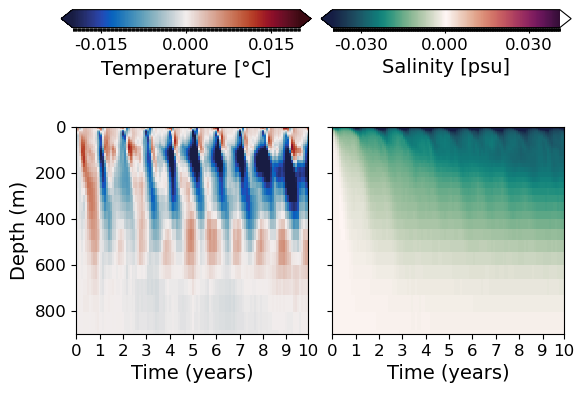

In [17]:
#Shelf area plot

fig, ax = plot_hovmoller_shelf(fsize = 14)

levels_temperature = np.arange(-0.02, 0.0201, 0.0001)

cf_temp = temp_hov.cf.plot(ax = ax[0],
                                  levels = levels_temperature,
                                  x = 'time',
                                  y = 'vertical',
                                  add_colorbar = False,
                                  label = None,
                                  cmap = cm.balance)

levels_salinity = np.arange(-0.04, 0.041, 0.0001)

cf_salt = salt_hov.cf.plot(ax = ax[1],
                               levels = levels_salinity,
                               x = 'time',
                               y = 'vertical',
                               add_colorbar = False,
                               label = None,
                               cmap = cm.curl)

## Beautification details
for i in range(len(ax)):
    if i < 2:
        ax[i].set_xlabel("Time (years)")
        ax[i].set_ylim(900, 0)
        ax[i].set_xlim(500,4000)
    else:
        ax[i].set_xlabel("")
        ax[i].set_xlim(500,4000)
        ax[i].set_ylim(5000, 900)

# Apply to both axes
for ax_i in [ax[0], ax[1]]:
    ax_i.set_xticks(tick_positions)
    ax_i.set_xticklabels(tick_labels)

ax[0].set_ylabel("Depth (m)")

ax[1].set_ylabel("")

# Colorbars
bar = plt.axes([0.11, 0.99, 0.25, 0.02])
cbar_1 = plt.colorbar(cf_temp, cax = bar, orientation = 'horizontal', extend='both', format= '%.3f')  
cbar_1.set_label("Temperature [$\degree$C]")

## Temperature colorbar (vertical on the right)
#bar = plt.axes([0.92, 0.55, 0.02, 0.25])  # [left, bottom, width, height]
#cbar_1 = plt.colorbar(cf_temp, cax=bar, orientation='vertical', extend='both', format='%.3f')
#cbar_1.set_label("Temperature [$\degree$C]")

bar = plt.axes([0.37, 0.99, 0.25, 0.02])
cbar_2 = plt.colorbar(cf_salt, cax = bar, orientation = 'horizontal', extend='both', format= '%.3f')  
cbar_2.set_label("Salinity [psu]")

for cbar in [cbar_1, cbar_2]:
    tick_locator = ticker.MaxNLocator(nbins=3) ## The ticker needs to called within the loop
    cbar.locator = tick_locator
    cbar.update_ticks()